# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [5]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

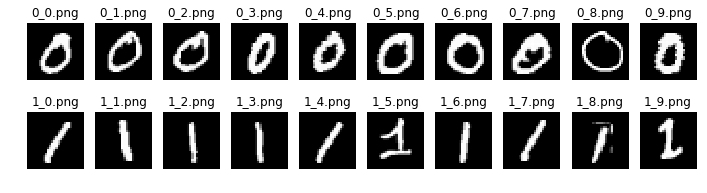

In [6]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

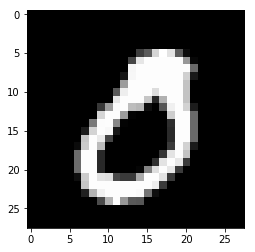

In [7]:
plt.imshow(zeros_im[0], cmap='gray')

In [202]:
from skimage.morphology import skeletonize
from skimage.util import invert
import skimage.measure as measure
import numpy as np
from skimage.segmentation import active_contour
import skimage.filters as filters
import skimage.morphology as mp

In [15]:
#Thresholding the image between two thresholds
def threshold(image, th1, th2):
    th_img = image.copy()
    th_img[th_img<th1] = 0
    th_img[th_img>th2] = 0
    th_img[(th_img>=th1) & (th_img<=th2)] = 1
    return th_img

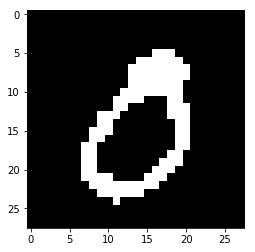

In [18]:
image = threshold(zeros_im[0],200,255)
plt.imshow(image, cmap='gray')

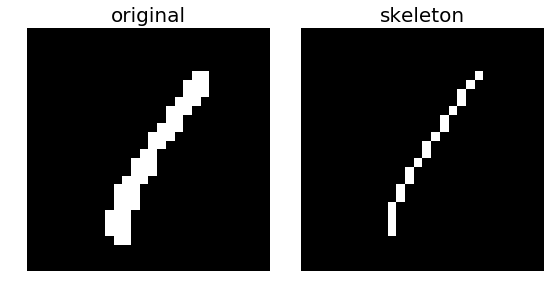

In [161]:

# Invert the horse image
image = threshold(ones_im[0],200,255)
#image = invert(zeros_im[0])


# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()



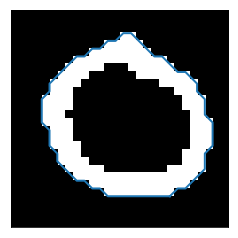

In [203]:
image = mp.dilation(threshold(zeros_im[8],200,255))
contours = measure.find_contours(image,0.5)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image, interpolation='nearest', cmap=plt.cm.gray)

ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()



In [99]:
def create_uk(snake):
    uk = []
    for pixel in snake:
        uk.append(pixel[0]+pixel[1] * 1j)
    return uk
uk = create_uk(snake)

(2470.814536135963-1.637290871186206j) (-52.210954956116794-91.43957319769756j)


In [206]:
def create_features(images):
    f1 = []
    f2 = []
    for im in images:
        im = mp.dilation(threshold(im,180,255))
        #im = skeletonize(im)
        contours = measure.find_contours(im,0.5)
        uk = create_uk(contours[0])
        f1.append(np.linalg.norm(np.fft.fft(uk)[1]))
        f2.append(np.linalg.norm(np.fft.fft(uk)[2]))  
    return f1 , f2

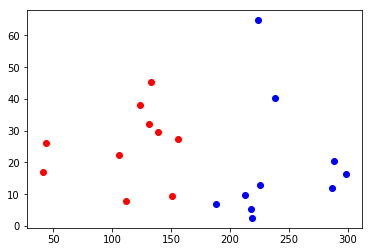

In [207]:
f1_ones,f2_ones = create_features(ones_im)
f1_zeros,f2_zeros = create_features(zeros_im)

plt.scatter(f1_ones,f2_ones, color = 'blue')  
plt.scatter(f1_zeros,f2_zeros, color = 'red')  

### 1.2 Fourier descriptors
Add your implementation and discussion

### 1.3 Additional method(s)


#### 1.3.1 Compacity
First we set the features to the Area and the Perimeter. The Perimeter will be described as the length of the contour

In [223]:
def create_features(images):
    f1 = []
    f2 = []
    for im in images:
        # Preporcessing
        im = mp.dilation(threshold(im,180,255)) 
        # Area
        A = np.sum(im == 1) 
        #perimeter
        P =  len(measure.find_contours(im,0.5)[0])
        
        f1.append(A)
        f2.append(P*P)
        
    return f1,f2

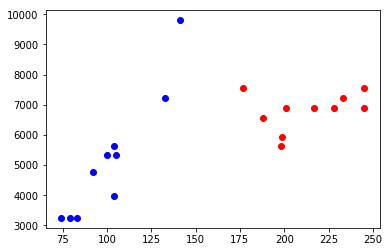

In [224]:
f1_ones, f2_ones = create_features(ones_im)
f1_zeros,f2_zeros = create_features(zeros_im)

plt.scatter(f1_ones,f2_ones, color = 'blue')  
plt.scatter(f1_zeros,f2_zeros, color = 'red')

By the way we choose the Perimeter P this method is also invariant to translation and rotation and the result is also quite ok